# Coordinates Testing
Test some better coordinates handling

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
import astropy.time
from sunpy.sun import constants
from sunpy.map import Map,GenericMap
import sunpy.coordinates
from sunpy.util.metadata import MetaDict

import synthesizAR
import synthesizAR.extrapolate
from synthesizAR.util import heeq_to_hcc_coord

%matplotlib inline

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
arr_shape = [ 100, 100] * u.pixel
obs = sunpy.coordinates.ephemeris.get_earth()
blc = SkyCoord(-150 * u.arcsec, -150 * u.arcsec,frame=sunpy.coordinates.Helioprojective(observer=obs))
trc = SkyCoord(150 * u.arcsec, 150 * u.arcsec, frame=sunpy.coordinates.Helioprojective(observer=obs))
centers = SkyCoord(
    [65,
     -65,
     #0,
     #0
    ]*u.arcsec,
    [0,
     0,
     #55,
     #-55
    ]*u.arcsec,
    frame=sunpy.coordinates.Helioprojective(observer=obs))
sigmas = u.Quantity([[15,15],
                     [15,15],
                     #[10,10],
                     #[10,10]
                    ],'arcsec')
amplitudes = u.Quantity([1e3, -1e3, 
                         #1e3, -1e3
                        ], 'Gauss')
magnetogram = synthesizAR.extrapolate.synthetic_magnetogram(blc, trc, arr_shape, centers, sigmas, amplitudes, observer=obs)

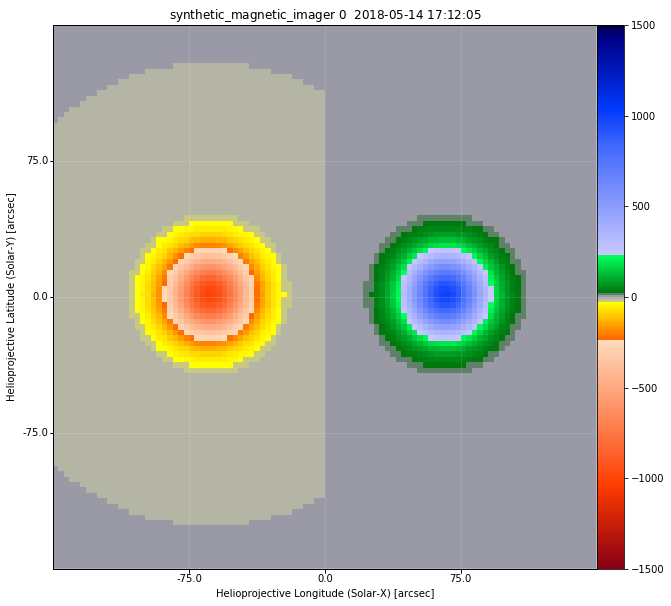

In [3]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=magnetogram)
im = magnetogram.plot(axes=ax,cmap='hmimag',
                      vmin=-1.5e3,vmax=1.5e3)
fig.colorbar(im,ax=ax,pad=0.)

In [4]:
shape_z = 100*u.pixel
width_z = 0.3*const.R_sun
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram,width_z,shape_z)
B_field = extrapolator.extrapolate()

In [5]:
fieldlines = extrapolator.trace_fieldlines(B_field, 200)

yt : [INFO     ] 2018-05-14 12:15:11,590 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-14 12:15:11,591 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-05-14 12:15:11,593 Parameters: domain_left_edge          = [-1.09429777e+10 -1.09445904e+10  0.00000000e+00]
yt : [INFO     ] 2018-05-14 12:15:11,594 Parameters: domain_right_edge         = [1.09485425e+10 1.09501560e+10 2.08710000e+10]
yt : [INFO     ] 2018-05-14 12:15:11,595 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-05-14 12:15:12,214 AMRKDTree rebuilt, Final Volume: 1.000366e+31
Streamlining: 100%|██████████| 200/200 [00:00<00:00, 374.79it/s]
yt : [INFO     ] 2018-05-14 12:15:13,138 AMRKDTree rebuilt, Final Volume: 1.000366e+31
Streamlining: 100%|██████████| 84/84 [00:00<00:00, 386.66it/s]
yt : [INFO     ] 2018-05-14 12:15:13,660 AMRKDTree rebuilt, Final Volume: 1.000366e+31
Streamlining: 100%|██████████| 41/41 [00:00<00:00, 296.67it/s]
yt : [INFO     ] 2018-05

FloatProgress(value=0.0)

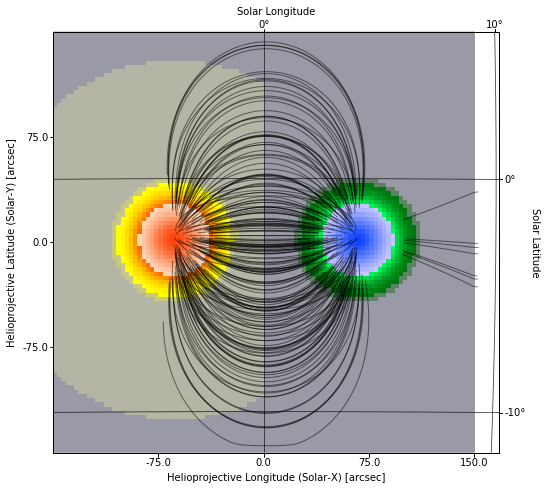

In [7]:
extrapolator.peek(fieldlines,line_frequency=1)

In [8]:
ds = synthesizAR.extrapolate.magnetic_field_to_yt_dataset(B_field.x, B_field.y, B_field.z,
                                                          extrapolator.range.x, extrapolator.range.y,
                                                          extrapolator.range.z)
lines = synthesizAR.extrapolate.trace_fieldlines(ds,100,)

yt : [INFO     ] 2018-05-14 10:23:41,553 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-14 10:23:41,556 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-05-14 10:23:41,557 Parameters: domain_left_edge          = [-1.09420489e+10 -1.09436874e+10  0.00000000e+00]
yt : [INFO     ] 2018-05-14 10:23:41,558 Parameters: domain_right_edge         = [1.09476123e+10 1.09492516e+10 2.08710000e+10]
yt : [INFO     ] 2018-05-14 10:23:41,560 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-05-14 10:23:42,011 AMRKDTree rebuilt, Final Volume: 1.000199e+31
Streamlining: 100%|██████████| 100/100 [00:00<00:00, 408.19it/s]
yt : [INFO     ] 2018-05-14 10:23:42,609 AMRKDTree rebuilt, Final Volume: 1.000199e+31
Streamlining: 100%|██████████| 38/38 [00:00<00:00, 347.57it/s]
yt : [INFO     ] 2018-05-14 10:23:43,033 AMRKDTree rebuilt, Final Volume: 1.000199e+31
Streamlining: 100%|██████████| 15/15 [00:00<00:00, 280.93it/s]
yt : [INFO     ] 2018-05

In [15]:
x_heeq,y_heeq,z_heeq = synthesizAR.extrapolate.local_to_heeq(*lines[0][0].T*u.cm,magnetogram.center)

In [16]:
line_sc = SkyCoord(x=x_heeq, y=y_heeq, z=z_heeq, frame='heliographic_stonyhurst', representation='cartesian')

In [23]:
foo = line_sc.transform_to('heliographic_stonyhurst').transform_to(sunpy.coordinates.Helioprojective(observer=magnetogram.observer_coordinate))

In [24]:
bar = heeq_to_hcc_coord(x_heeq,y_heeq,z_heeq,magnetogram.observer_coordinate).transform_to(sunpy.coordinates.Helioprojective(observer=magnetogram.observer_coordinate))

In [30]:
foo.cartesian.xyz == bar.cartesian.xyz

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [False, False, False, False, False,  Tr

In [37]:
foo.cartesian.xyz.shape

(3, 60)

In [35]:
np.fabs(foo.cartesian.z - bar.cartesian.z)/np.fabs(bar.cartesian.z)

<Quantity [2.20705980e-16, 6.25767680e-16, 1.97648594e-16, 5.63274661e-16,
           1.78804840e-16, 0.00000000e+00, 1.63313248e-16, 0.00000000e+00,
           1.50505970e-16, 2.89889950e-16, 0.00000000e+00, 0.00000000e+00,
           2.62019515e-16, 1.27147271e-16, 3.70870052e-16, 0.00000000e+00,
           2.34988157e-16, 2.29698760e-16, 4.49848638e-16, 2.20638166e-16,
           4.33636089e-16, 2.13444240e-16, 2.10502021e-16, 0.00000000e+00,
           6.17587682e-16, 0.00000000e+00, 2.02827633e-16, 6.05691711e-16,
           2.01353916e-16, 4.02392044e-16, 4.02846181e-16, 2.02035837e-16,
           0.00000000e+00, 2.04427108e-16, 4.12427068e-16, 4.16804483e-16,
           2.11001048e-16, 2.14020738e-16, 4.34949030e-16, 0.00000000e+00,
           0.00000000e+00, 1.15309103e-16, 2.36005011e-16, 4.83891923e-16,
           1.24239529e-16, 1.27823223e-16, 2.63500382e-16, 0.00000000e+00,
           1.40759732e-16, 1.45918053e-16, 1.51573109e-16, 0.00000000e+00,
           0.00000000e+00

In [32]:
bar.cartesian.z

<Quantity [-32966.74435479, -34881.75173256, -36812.59478737,
           -38751.73937309, -40692.17366534, -42627.63167373,
           -44552.15793989, -46459.6571155 , -48343.31556452,
           -50198.06738773, -52018.78808311, -53800.40425322,
           -55537.5243875 , -57224.64637559, -58855.85190301,
           -60425.25210804, -61926.16444783, -63352.17149241,
           -64696.9402725 , -65953.75361985, -67115.7940605 ,
           -68176.65915631, -69129.57490031, -69968.49623977,
           -70687.52656234, -71281.22288431, -71745.23033957,
           -72075.85128021, -72270.33622409, -72327.05233725,
           -72245.5166634 , -72026.40605773, -71671.54800393,
           -71183.88229665, -70567.21710423, -69826.0974697 ,
           -68966.0804432 , -67993.01477635, -66913.19772194,
           -65733.28002828, -64459.86439001, -63099.59425265,
           -61659.34865454, -60145.31154803, -58563.95042497,
           -56922.03196741, -55225.40467667, -53479.74598135,
        

In [26]:
foo.data == bar.data

False

In [27]:
x,y,z = magnetogram.center.transform_to('heliographic_stonyhurst').cartesian.xyz

In [28]:
x

<Quantity 694935.51127238 km>

In [16]:
to_heeq(magnetogram.center)

(<Distance 694935.51127238 km>,
 <Distance 1094.42462854 km>,
 <Distance -32587.22770785 km>)

In [41]:
fieldlines[0][0].shape

(52, 3)

In [43]:
lines[0][0].shape

(60, 3)

In [44]:
foo = SkyCoord(x=const.R_sun, y=0.*u.km, z=0.*u.km, frame='heliographic_stonyhurst', representation='cartesian')

In [45]:
obs = sunpy.coordinates.ephemeris.get_earth()

In [46]:
foo.transform_to(sunpy.coordinates.Helioprojective(observer=obs))

AttributeError: 'HeliographicStonyhurst' object has no attribute 'lon'

In [48]:
foo.transform_to('heliographic_stonyhurst').transform_to(sunpy.coordinates.Helioprojective(observer=obs))

<SkyCoord (Helioprojective: obstime=None, rsun=695508.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2018-05-14 16:14:11.335975): (lon, lat, radius) in (deg, deg, AU)
    (0., -2.73117811, 1.01072722)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (0., 45.43088842, 1.50507734e+08)>

In [8]:
import sunpy

In [9]:
sunpy.version.version

'0.9.0'